# Saving and loading models

We look now at one very useful feature in Tensorflow: saving and loading a model.  
We will use as an example a subset of CIFAR, an image dataset whose images can be classified with a description label.  

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


## Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of 60K color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.  
The dataset is availbale inside Tensorflow and you can see an introduction and download it, on [the Toronto University web site](https://www.cs.toronto.edu/~kriz/cifar.html).

In [2]:
# Import the CIFAR-10 dataset and rescale the pixel values

(xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.cifar10.load_data()
xTrain = xTrain / 255.0 # rescale
xTest = xTest / 255.0

# Use smaller subset -- speeds things up
xTrain = xTrain[:10000]
yTrain = yTrain[:10000]
xTest = xTest[:1000]
yTest = yTest[:1000]

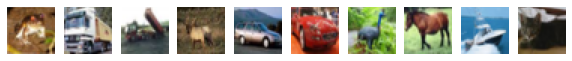

In [3]:
# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(xTrain[i])

## Saving and loading weights

Let's start by seeing how to save the weights of a model.  
We will train a model and save the resulting weights, just those parameters.  
Firstly we introduce two useful functions: to test the accuracy and to create a new model (a simple CNN)

In [4]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print(f'accuracy: {test_acc}')

In [5]:
# Introduce function that creates a new instance of a simple Convolutional Neural Network

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(4, 4)),
        Flatten(),
        Dense(units=32, activation='relu'),
        Dense(units=10, activation='softmax', name = 'output-10-classes')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### Create a simple convolutional neural network classifier

In [6]:
# Create an instance of the model and show model summary

model1 = get_new_model()
model1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         1160      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                12576     
_________________________________________________________________
output-10-classes (Dense)    (None, 10)                330       
Total params: 14,514
Trainable params: 14,514
Non-trainable params: 0
____________________________________________________

As you can see, it is a convolutional neural network with 6 layers in total and the final one classifies the input into one of ten classes.

In [7]:
# Test accuracy of the untrained model, around 10% (random)

get_test_accuracy(model1, xTest, yTest)


accuracy: 0.13099999725818634


The model is untrained, so the accuracy will be around 10% (10 possible classes = 1/10)

### Train model with checkpoints

It's possible to
save model weights automatically during
a training run using a built-in callback called the
**ModelCheckpoint**.   
  
First 
we're creating
the ModelCheckpoint object. The constructor of this callback has one required argument, which is the *file path*. This is the name that the callback will use to save the model.  
There is another keyword argument here, specifying *save_weights_only*. This means that only the model weights will be saved by this callback
and not the architecture.  

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [9]:
# Create Tensorflow checkpoint object

path = 'modelCheckpoints/chechpoint'
checkpoint = ModelCheckpoint(path, save_weights_only=True, save_freq='epoch', verbose=1)


Lastly we need to train the model, by calling the usual *model.fit*, parsing in the training
inputs and outputs and setting it to train for few epochs. Just as we saw previously, we're using the
callbacks keyword argument, parsing in a list which contains our *ModelCheckpoint* callback object. This callback will save the model weights
**after every epoch**.  
  
Now, because we're using the same file name
to save them model, the saved weights will get
overwritten every epoch. 

In [10]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch

history1 = model1.fit(xTrain, yTrain, epochs=3, batch_size=64, callbacks=[checkpoint], verbose=1)


Train on 10000 samples
Epoch 1/3
 9984/10000 [============================>.] - ETA: 0s - loss: 2.0744 - accuracy: 0.2434
Epoch 00001: saving model to modelCheckpoints/chechpoint
10000/10000 [==============================] - 12s 1ms/sample - loss: 2.0737 - accuracy: 0.2435
Epoch 2/3
 9984/10000 [============================>.] - ETA: 0s - loss: 1.6806 - accuracy: 0.3923
Epoch 00002: saving model to modelCheckpoints/chechpoint
10000/10000 [==============================] - 11s 1ms/sample - loss: 1.6807 - accuracy: 0.3923
Epoch 3/3
 9984/10000 [============================>.] - ETA: 0s - loss: 1.5325 - accuracy: 0.4486
Epoch 00003: saving model to modelCheckpoints/chechpoint
10000/10000 [==============================] - 11s 1ms/sample - loss: 1.5331 - accuracy: 0.4482


In [11]:
# Have a look at what the checkpoint creates

! ls -lh modelCheckpoints


total 368
-rw-r--r--  1 Massimo  staff   174K Sep 20 13:39 chechpoint.data-00000-of-00001
-rw-r--r--  1 Massimo  staff   2.0K Sep 20 13:39 chechpoint.index
-rw-r--r--  1 Massimo  staff    77B Sep 20 13:39 checkpoint


Now that training is finished, you see that it saved every epoch and in total produced 3 files. The first one has the actual weights resulting from all the epochs (it was overwritten every epoch).

In [12]:
# Evaluate the performance of the trained model

get_test_accuracy(model1, xTest, yTest)


accuracy: 0.45100000500679016


Of course, after the training the accuracy improved and now is 45% with just 3 epochs.


### Create new model, load weights

So we've saved the model
weights during a training run, how do we load weights that
have been previously saved?  
Since we have only saved the weights and not the
model architecture, we still need the
code to rebuild the same model architecture that the weights were saved from. 
  
We can then load
the weights we have saved from a previous
training run by calling *model.load_weights* and parsing in the same file name that we
used to save the weights. 

In [13]:
# Create a new instance of the (initialised) model, accuracy around 10% again

model0 = get_new_model()
get_test_accuracy(model0, xTest, yTest)


accuracy: 0.0860000029206276


In [14]:
# Load weights -- accuracy is the same as the trained model

model0.load_weights(path)
get_test_accuracy(model0, xTest, yTest)


accuracy: 0.45100000500679016


#### Clear directory

Optional, but not to mess up with further experiments we remove all files

In [15]:
! rm -r modelCheckpoints

## Model saving criteria

### Create more customised checkpoint

More possibilities to save the model are available, for example the weights can be saved at a different frequency or
according to some criteria.  
The *ModelCheckpoint*
callback comes with a few extra options that
help to have a little bit more customization.  
For example, we are goiing to create a checkpoint that saves the model weights every
5,000 training points. Now, instead of writing *save_frequency* is
epoch which it was before, we put a number, which is the number of training points after it saves.   
And TensorFlow has this neat trick
where you can format the checkpoint file path using variables, in this case we add the epoch and batch.  

The other parameters are the same: it's *save_weights_only=True* so we're still saving only the weights and *verbose=1* so we have some
progress printed statements during the training.  
The new checkpoint is called  cp_5000 and is added as a callback in the *model.fit*

In [16]:
# Create Tensorflow checkpoint object with epoch and batch details

cp_5000_path = 'model_checkpoints_5000/checkpoint_{epoch:02d}_{batch:04d}'
cp_5000 = ModelCheckpoint(cp_5000_path, save_weights_only=True, save_freq=5000, verbose=1)


In [17]:
# Create and fit model with checkpoint

model2 = get_new_model()
history2 = model2.fit(xTrain, yTrain, 
                    epochs=3, batch_size=10,  
                    validation_data=(xTest, yTest), 
                    callbacks=[cp_5000])

Train on 10000 samples, validate on 1000 samples
Epoch 1/3
 4990/10000 [=============>................] - ETA: 8s - loss: 2.0632 - accuracy: 0.2208
Epoch 00001: saving model to model_checkpoints_5000/checkpoint_01_0499
 9970/10000 [============================>.] - ETA: 0s - loss: 1.8896 - accuracy: 0.3024
Epoch 00001: saving model to model_checkpoints_5000/checkpoint_01_0999
10000/10000 [==============================] - 16s 2ms/sample - loss: 1.8891 - accuracy: 0.3028 - val_loss: 1.6034 - val_accuracy: 0.4320
Epoch 2/3
 4990/10000 [=============>................] - ETA: 7s - loss: 1.5613 - accuracy: 0.4303
Epoch 00002: saving model to model_checkpoints_5000/checkpoint_02_0499
 9980/10000 [============================>.] - ETA: 0s - loss: 1.5430 - accuracy: 0.4425
Epoch 00002: saving model to model_checkpoints_5000/checkpoint_02_0999
10000/10000 [==============================] - 15s 2ms/sample - loss: 1.5431 - accuracy: 0.4422 - val_loss: 1.4803 - val_accuracy: 0.4570
Epoch 3/3
 4970

What happened here is that - after 5000
training points - it prints "saving model to model_checkpoints_5000/checkpoint_01_0499"  
The 01 refers to the epochs,
it's the first epoch. And the 499 is essentially the 500th batch. And that's why I chose
 *batch_size* as 10 in the *model.fit*: so 5000 training points
corresponds to 500 batches.  
Basically, every epoch it has the
model_checkpoints saved. The checkpoint_01_499 was
after the 500th batch and checkpoint_01_999 was after the 1000th batch,
essentially the end of the epoch. And does the same thing for
epochs 2 and 3.  

In [18]:
# Have a look at what the checkpoint creates

!ls -lh model_checkpoints_5000


total 2168
-rw-r--r--  1 Massimo  staff    93B Sep 20 13:44 checkpoint
-rw-r--r--  1 Massimo  staff   174K Sep 20 13:44 checkpoint_01_0499.data-00000-of-00001
-rw-r--r--  1 Massimo  staff   2.0K Sep 20 13:44 checkpoint_01_0499.index
-rw-r--r--  1 Massimo  staff   174K Sep 20 13:44 checkpoint_01_0999.data-00000-of-00001
-rw-r--r--  1 Massimo  staff   2.0K Sep 20 13:44 checkpoint_01_0999.index
-rw-r--r--  1 Massimo  staff   174K Sep 20 13:44 checkpoint_02_0499.data-00000-of-00001
-rw-r--r--  1 Massimo  staff   2.0K Sep 20 13:44 checkpoint_02_0499.index
-rw-r--r--  1 Massimo  staff   174K Sep 20 13:44 checkpoint_02_0999.data-00000-of-00001
-rw-r--r--  1 Massimo  staff   2.0K Sep 20 13:44 checkpoint_02_0999.index
-rw-r--r--  1 Massimo  staff   174K Sep 20 13:44 checkpoint_03_0499.data-00000-of-00001
-rw-r--r--  1 Massimo  staff   2.0K Sep 20 13:44 checkpoint_03_0499.index
-rw-r--r--  1 Massimo  staff   174K Sep 20 13:44 checkpoint_03_0999.data-00000-of-00001
-rw-r--r--  1 Massimo  staff   

As you can see, this time is not overwriting the file with the weights but is creating new files every 5000 training points. And notice now that
the file name has changed accordingly the format we have set in the model checkpoint file path.

### Work with model saving criteria

Now we're going to create a checkpoint that only saves the model weights that had the
highest testing or validation accuracy.  
Basically we see if we can just find the point at which it starts overfitting and
use just those weights. So let's go ahead and
create a new instance of this model.

In [19]:
# Create a new instance of untrained model

model3 = get_new_model()


We create a checkpoint file path called *model_checkpoints_best* with a directory
called *model_checkpoints_best*. And then we create an instance of ModelCheckpoint, in the smae way as above but with filepath=checkpoint_best_path.  
Again, it will save just the weights,
so save_weights_only=True and we go back to do save_freq='epoch', so saving every epoch.  
The critical argument here is the *monitor*, that it
is what tensorflow uses to decide whether to save the weights or not. There fore we have *monitor='val_accuracy'* and
 *save_best_only=True*. So it only saves the weights with
the highest value of the monitor. In this case, it's the val_accuracy.

In [20]:
# Create Tensorflow checkpoint object which monitors the validation accuracy

checkpoint_best_path = 'model_checkpoints_best/checkpoint'
cp_best = ModelCheckpoint(checkpoint_best_path,
                          save_weights_only=True,
                          verbose=1,
                          save_best_only=True,
                          monitor='val_accuracy',
                          save_freq='epoch')


Now, let's use a validation_data so it gives us some sort of
validation outputs, as well. We need this for the monitor.  
Verbose is turned off as we train for more epochs here, otherwise we get too many printed statements.

In [21]:
# Fit the model and save only the weights with the highest validation accuracy

history3 = model3.fit(xTrain, yTrain, epochs=20, 
                      validation_data=(xTest,yTest), 
                      batch_size=10, callbacks=[cp_best], verbose=0)



Epoch 00001: val_accuracy improved from -inf to 0.37000, saving model to model_checkpoints_best/checkpoint

Epoch 00002: val_accuracy improved from 0.37000 to 0.50500, saving model to model_checkpoints_best/checkpoint

Epoch 00003: val_accuracy did not improve from 0.50500

Epoch 00004: val_accuracy improved from 0.50500 to 0.54700, saving model to model_checkpoints_best/checkpoint

Epoch 00005: val_accuracy did not improve from 0.54700

Epoch 00006: val_accuracy improved from 0.54700 to 0.56200, saving model to model_checkpoints_best/checkpoint

Epoch 00007: val_accuracy did not improve from 0.56200

Epoch 00008: val_accuracy did not improve from 0.56200

Epoch 00009: val_accuracy improved from 0.56200 to 0.56600, saving model to model_checkpoints_best/checkpoint

Epoch 00010: val_accuracy did not improve from 0.56600

Epoch 00011: val_accuracy did not improve from 0.56600

Epoch 00012: val_accuracy improved from 0.56600 to 0.56700, saving model to model_checkpoints_best/checkpoint



So you see here, it's every epoch. When the *val_accuracy* improves,
it saves. If in one epoch the accuracy doesn't improve,
it doesn't do anything. Note that it's using the same
file name again every time, so it's going to overwrite this file. So at the end I will  be left with
only checkpoints that have the highest val_accuracy. Let's go ahead and
plot the training and testing curves. 

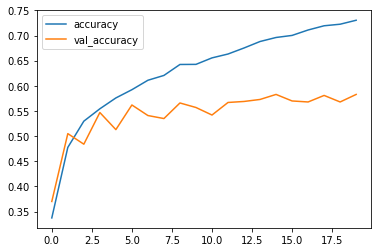

In [22]:
# Plot training and testing curves

import pandas as pd

df = pd.DataFrame(history3.history)
df.plot(y=['accuracy', 'val_accuracy']);

Our training accuracy goes up towards 1 (and will likely continue doing it after the 20 epochs) because the model is essentially
memorizing the training data set. But the *val_accuracy* doesn't really
improve after it reached around  0.58 during the 15th epoch;  it kind of plateaus off there  and
that is the highest *val_accuracy*.

In [23]:
# Inspect the checkpoint directory

! ls -lh model_checkpoints_best


total 368
-rw-r--r--  1 Massimo  staff    77B Sep 20 13:53 checkpoint
-rw-r--r--  1 Massimo  staff   174K Sep 20 13:53 checkpoint.data-00000-of-00001
-rw-r--r--  1 Massimo  staff   2.0K Sep 20 13:53 checkpoint.index


let's see what is actually
in this directory right now. You see just three files: the checkpoint, checkpoint.data
and checkpoint.index. And we expect that this is going to
be the highest *val_accuracy*. 

#### Clear directory

In [24]:
! rm -r model_checkpoints_5000 model_checkpoints_best

## Saving the entire model

Of course, you might also want to
save the entire model, weights and architecture combined.

### Create checkpoint that saves whole model, not just weights

That's easy. We're again using
the *ModelCheckpoint* callback, and we're passing it in to
the *model.fit* method. This callback will save the model
at the end of every epoch. The only difference is in the argument
*save_weights_only* to be false. So the callback will save the entire
model at the end of every epoch and not just the weights. In fact, this is the default value for
this keyword argument
so you don't have to create a new instance with the same architecture

In [25]:
# Create Tensorflow checkpoint object

cp_path = 'My_Checkpoints'
cp = ModelCheckpoint(cp_path, save_weights_only=False, save_freq='epoch', verbose=1)


In [26]:
# Create and fit model with checkpoint

model4 = get_new_model()
model4.fit(xTrain, yTrain, epochs=3, callbacks=[cp])


Train on 10000 samples
Epoch 1/3
 9984/10000 [============================>.] - ETA: 0s - loss: 2.0009 - accuracy: 0.2586
Epoch 00001: saving model to My_Checkpoints
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: My_Checkpoints/assets
10000/10000 [==============================] - 14s 1ms/sample - loss: 2.0004 - accuracy: 0.2588
Epoch 2/3
 9952/10000 [============================>.] - ETA: 0s - loss: 1.6732 - accuracy: 0.3938
Epoch 00002: saving model to My_Checkpoints
INFO:tensorflow:Assets written to: My_Checkpoints/assets
10000/10000 [==============================] - 14s 1ms/sample - loss: 1.6735 - accuracy: 0.3941
Epoch 3/3
 9984/10000 [============================>.] - ETA: 0s - loss: 1.5549 - accuracy: 0.4474
Epoch 00003: saving model to My_Checkpoints
INFO:tensorflow:Assets written to: My_Checkpoints/assets
10000/10000 [==============================] - 13s 1ms/sample - loss: 1.5552 - accuracy: 0.4472


Now, because we're saving the entire model
and not just the weights, the file path is used to create a subdirectory
within the current working directory. Inside that, you'll find two more
subdirectories, assets and variables. The assets folder is where
files can be stored that are used by the TensorFlow graph. In our simple example,
this folder would be empty. The variables folder contains
the saved weights of the model. These file names should look familiar
from when we were saving weights only. The last file here, saved_model.pb, is the file that stores
the TensorFlow graph itself. You can think of this as
storing the model architecture. So it contains all the information from
when we built and compiled the model, including the optimizer state, in case we want to resume
training from a saved model. 
  
It's also possible to only save the model
architecture without the weights

In [27]:
# Have a look at what the checkpoint creates

!ls -lh My_Checkpoints


total 256
drwxr-xr-x  2 Massimo  staff    64B Sep 20 13:59 assets
-rw-r--r--  1 Massimo  staff   121K Sep 20 13:59 saved_model.pb
drwxr-xr-x  4 Massimo  staff   128B Sep 20 13:59 variables


In [28]:
# Enter variables directory

!ls -lh My_Checkpoints/variables


total 368
-rw-r--r--  1 Massimo  staff   177K Sep 20 13:59 variables.data-00000-of-00001
-rw-r--r--  1 Massimo  staff   2.1K Sep 20 13:59 variables.index


### Create new model from scratch

So what about loading an entire model? Well, this time, we don't need
the original code that was used to build the model, so
the loading code looks a lot simpler: just  import and call 
the *load_model* function from the *tensorflow.keras.models* module. And to load the model, I just pass the path to the model folder, and it will return the complete model
instance, architecture and saved weights.  
We could now do everything that we've done
before with this loaded model instance. We could print out the model summary. We could **resume training**,
using the *fit* method. We could run *evaluate* to
evaluate the loss in metrics on a held-out test set. Or get model predictions from unseen
examples using *predict*. 

In [29]:
# Delete model

del model4


In [30]:
from tensorflow.keras.models import load_model

In [31]:
# Reload model from scratch

model4 = load_model(cp_path) 


In [32]:
get_test_accuracy(model4, xTest, yTest)


accuracy: 0.43700000643730164


#### Use the .h5 format to save model

Just as a note, you can also save the model using the keras format, just by adding the .h5 extension to the file name.  
The Keras format is more synthetic: just one file is saved

modelToBeSaved.save('my_model.h5')  
modelRetrieved = load_model('my_model.h5')

#### Clear directory

In [33]:
! rm -r My_Checkpoints

## Loading pre-trained Keras models
One of the most useful features of loading a module is that there are  many
pre-trained models available out there that you can download and experiment with in
your applications.  
We'll take a look at one
resource for loading pre-trained image
classification models which is through the Keras API. If you go to
keras.io/applications, you'll see a number of
different architectures that are available
for you to download.  
Documentation is also available for individual model
architectures, so you can see how
to use them and what the options are
for downloading them. Let's take a look at an example.

### Import and build Keras ResNet50 model

We'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications to be trained on our original dataset. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. The paper it comes from is:
  
Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.
  
This model may take some time to download.

In [34]:
from tensorflow.keras.applications import ResNet50

modelRN = ResNet50(weights='imagenet')

To load this model, you
import the ResNet-50 class from the
tensorflow.keras.applications.resnet50 module. Then create an instance of the 
ResNet50 object and when this line
of code executes, the model architecture in
weights will be downloaded  into a
hidden folder in your home directory inside a
subdirectory called models. You can also see I've passed in the keyword arguments,
weights equals ImageNet. That means that the model will be loaded with weights that have been learned from training
on the ImageNet dataset. Otherwise, if you
set this to none, then the weights will be randomly initialized for a fresh training. 

Another interesting
option you can use is the include top keyword argument. By default, this is equal
to true in which case the complete classifier model is downloaded and instantiated. However, if you set
include top to be false, the fully connected layer at the top of the
network isn't loaded. So what you end up with is a headless model that you can use for things like transfer
learning applications. 

In [35]:
modelRN.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

it is a pretty big model! It has dozens of layers and 25 milion parameters

#### Import and preprocess 3 sample images
  
  I'm using the load image function to load in an image I've got stored in the
current working directory. I'm also passing the
target size keyword and setting that to 224 by 224. If you take a look at the
documentation you'll see that this is the **required input size for the ResNet-50 classifier model**, and the load image function can handle any necessary
resizing for us. 

In [36]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('../datasets/lemon.jpg', target_size=(224, 224))
viaduct_img = load_img('../datasets//viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('../datasets//water_tower.jpg', target_size=(224, 224))

### Use ResNet50 model to classify images

First of all, we have
instantiated the model using weights that have been learned from training
on ImageNet, and we left include_top to be true, so we are getting the complete model including the final
classification layer. No need to train further.  
  
In the Keras module, there are some really
useful tools for handling images and here I'm importing the image module from *tensorflow.keras.preprocessing*.  
The model itself needs to take in a numpy array as an input. Again, the image module
can take care of this by forcing  the
image to an array. The final thing we need to do to get the image
ready for the model is to preprocess it according
to the model requirements.  
You can see here I'm importing the *preprocess_input* function from the
*tensorflow.keras.applications.resnet50* module and that
we're also adding an extra dummy
dimension to the input.

The image is
preprocessed and ready, so we just need to
pass it into the *model.predict* method to
get the model predictions.  
These predictions will be a
numpy array of probabilities but of course what we
want to know is what the classes are that the model is predicting for this image. So the final function
that we're importing is the *decode_predictions* function. This function will take the
model predictions and return a list of tuples corresponding
to the class code, its description in plain
English that we can understand and the network probability. The *top = 5* argument
just means that we're only retrieving the top
five model predictions. 

In [37]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

def get_top_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(modelRN.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

##### Image 1: lemon

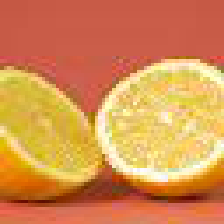

In [38]:
# Display image

lemon_img


In [39]:
# Display top 5 predictions

get_top_predictions(lemon_img)


,prediction,probability
1,consomme,0.227801
2,lemon,0.221758
3,eggnog,0.151335
4,ladle,0.0400882
5,spotlight,0.0291972


##### Image 2: viaduct

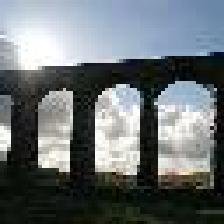

In [40]:
# Display image

viaduct_img

In [41]:
# Display top 5 predictions

get_top_predictions(viaduct_img)


,prediction,probability
1,vault,0.367951
2,prison,0.111741
3,viaduct,0.110738
4,window_screen,0.0882305
5,fire_screen,0.0206751


##### Image 3: water tower

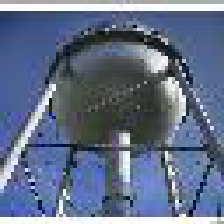

In [42]:
# Display image

water_tower_img


In [43]:
# Display top 5 predictions

get_top_predictions(water_tower_img)


,prediction,probability
1,solar_dish,0.384682
2,ladle,0.196178
3,planetarium,0.116683
4,strainer,0.0499897
5,jigsaw_puzzle,0.0219474


There are many more models
that can be downloaded and used in a similar way
through the Keras API. So be sure to take
a look again at the website we saw earlier
to see all the options.